# Test regression deep Learning model with Pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for plot
%matplotlib inline

import torch 
import torch.nn as nn # For neural network building
import torch.nn.functional as F # For activation function
from torch.utils import data  # For data handling
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler # Same as previous
from sklearn.model_selection import train_test_split # For split

### Chargement des données

In [15]:
X = pd.read_csv('../X_train_J01Z4CN.csv')
X.drop('city', axis=1, inplace=True)
y = pd.read_csv('../y_train_OXxrJt1.csv')
y.drop('id_annonce', axis=1, inplace=True)
X.drop('id_annonce', axis=1, inplace=True)

<AxesSubplot: ylabel='Count'>

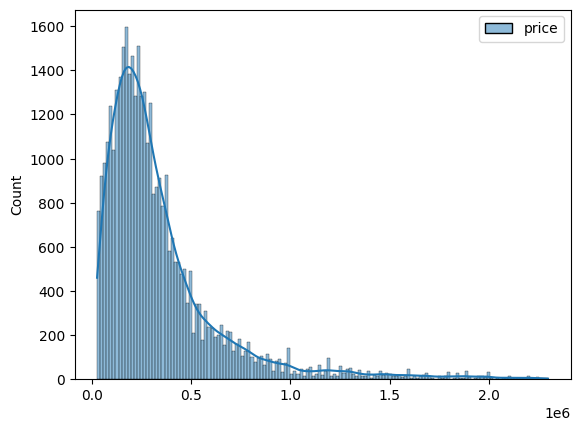

In [3]:
import seaborn as sns # for data visualization
sns.histplot(y, kde=True)

In [16]:
# Preprocessing function
def preprocess(df):
    df = df.copy() # Make copy so we don't ruin the original dataframe
    df = df.drop(columns=["Id"], errors='ignore') # Drop Id column
    
    numeric_cols = df.select_dtypes(np.number).columns # Numerical column name
    numeric_cols = numeric_cols.drop("SalePrice", errors='ignore') # Drop label
    categorical_cols =  df.select_dtypes(include=['object']).columns # Categorical column name
    
    df_categorical = pd.get_dummies(df[categorical_cols], dummy_na=True) # OneHotEncoding, dummy_na create another column to indicate if the cell contain NA
    
    df_numerical = df[numeric_cols].apply(lambda x: (x - x.mean()) / (x.std())) # Normalize every numerical column
    df_numerical = df_numerical.fillna(0) # Fill in missing value with mean 0
    
    df = pd.concat([df_numerical, df_categorical], axis=1) # Bind numerical column and categorical column
    
    return df

In [17]:
# Get inputs and target
df_train_y = y.copy() # Copy the target
df_train_y = np.log(df_train_y, where=df_train_y != 0) # Scale the target
df_train_X = preprocess(X) # Preprocess the inpu

<AxesSubplot: ylabel='Count'>

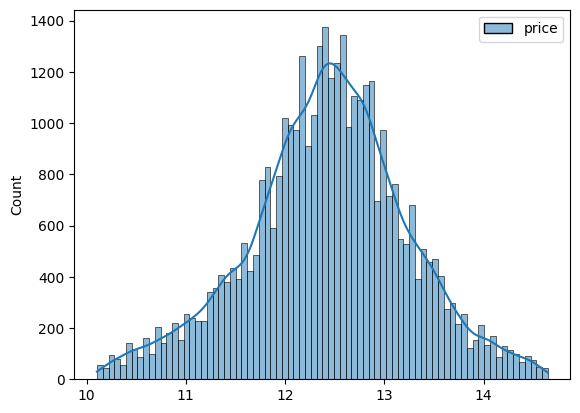

In [6]:
# Check the distribution of the data
sns.histplot(df_train_y, kde=True)

In [18]:
# Split the data into 80% training and 20% validation
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_train_X, df_train_y, 
                                                                        train_size=0.8, random_state=42)

In [20]:
# Building a model
class Model(nn.Module):
    def __init__(self, D_in=73, H=50, D_out=1, Hn=4):
        super().__init__()
        self.Hn = Hn # Number of hidden layer
        self.activation = nn.Softplus() # Activation function
        
        self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation]) # First hidden layer
        for i in range(self.Hn - 1):
            self.layers.extend([nn.Linear(H, H), self.activation]) # Add hidden layer
        self.layers.append(nn.Linear(H, D_out)) # Output layer
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [21]:
# Setting seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# Set seed for reproducibility
set_seed(123)

In [22]:
# Set device to gpu (cuda) if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
# Data for validation
y_val = torch.tensor(df_val_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_val = torch.tensor(df_val_X.values).float().to(device)

# Prepare data for batch training
y_train = torch.tensor(df_train_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_train = torch.tensor(df_train_X.values).float().to(device)
dataset = TensorDataset(X_train, y_train) # Make X,y into dataset so we can work with DataLoader which iterate our data in batch size
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define Model,Optimizer, Criterion
model = Model().to(device) # Define model and send to gpu
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001) # What approach we use to minimize the gradient
criterion = nn.MSELoss() # Our loss function

In [24]:
from tqdm import tqdm # For progress bar
train_losses = [] # Store the training loss
val_losses = [] # Store the validation loss
epochs = 250 # Number of time we go over the whole dataset

for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        # Forward propagation
        y_pred = model(X) # Make prediction by passing X to our model
        loss = criterion(y_pred, y) # Calculate loss 
        running_loss += loss.item() # Add loss to running loss
        
        # Backward propagation
        optimizer.zero_grad() # Empty the gradient (look up this function)
        loss.backward() # Do backward propagation and calculate the gradient of loss with respect to every parameters (that require gradient)
        optimizer.step() # Adjust parameters to minimize loss
    
    # Append train loss
    train_losses.append(running_loss/(batch + 1)) # Add the average loss of this iteration to training loss
    
    # Check test loss
    y_pred = model(X_val)
    val_loss = criterion(y_pred, y_val).item()
    val_losses.append(val_loss)

  0%|          | 0/250 [00:00<?, ?it/s]/opt/anaconda3/envs/Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/Pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7474, 1, 1])) that is different to the input size (torch.Size([7474, 1])). This will likely le

In [25]:
# Plotting loss
def plot_loss(losses, axes=None, epoch_start = 0):
    sns.set_theme(style="darkgrid")
    x = [i for i in range(1 + epoch_start, len(losses) + 1)]
    sns.lineplot(ax=axes, x=x, y=losses[epoch_start:])
    
    
def plot_epoch_loss(train_losses, test_losses, epoch1=0, epoch2=10, epoch3=50, epoch4=150):
    fig, axes = plt.subplots(2, 2, figsize=(12,6), constrained_layout = True)
    fig.suptitle("Losses against Epochs")

    axes[0][0].set_title('Epoch Start at ' + str(epoch1))
    plot_loss(train_losses, axes[0][0], epoch1)
    plot_loss(test_losses, axes[0][0], epoch1)

    axes[0][1].set_title('Epoch Start at ' + str(epoch2))
    plot_loss(train_losses, axes[0][1], epoch2)
    plot_loss(test_losses, axes[0][1], epoch2)

    axes[1][0].set_title('Epoch Start at ' + str(epoch3))
    plot_loss(train_losses, axes[1][0], epoch3)
    plot_loss(test_losses, axes[1][0], epoch3)

    axes[1][1].set_title('Epoch Start at ' + str(epoch4))
    plot_loss(train_losses, axes[1][1], epoch4)
    plot_loss(test_losses, axes[1][1], epoch4)


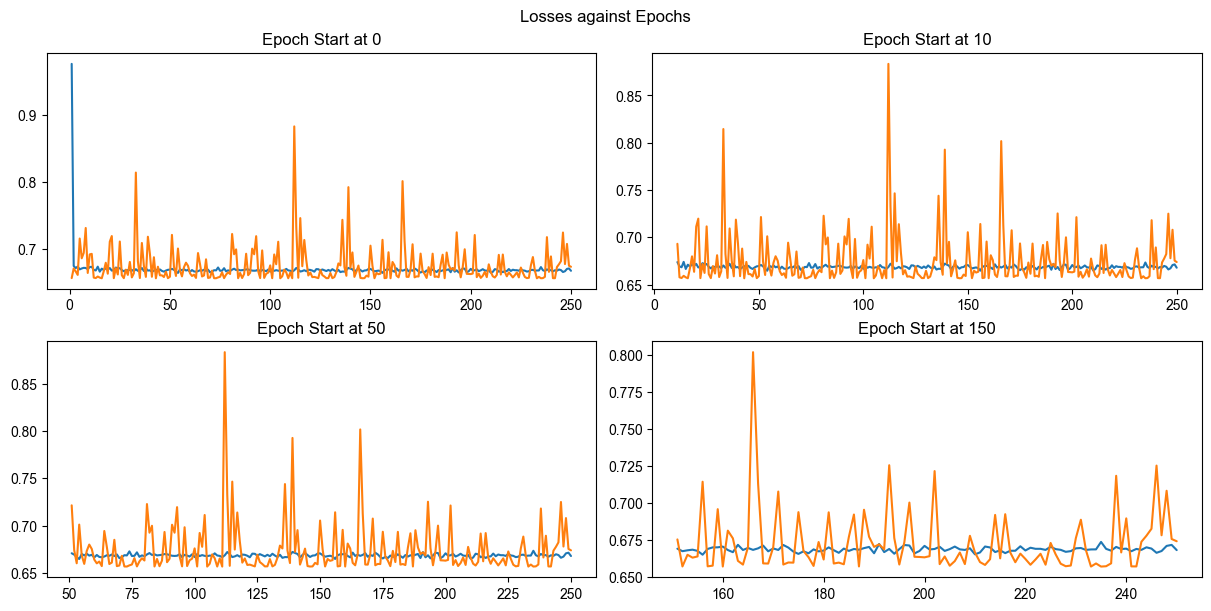

In [26]:
plot_epoch_loss(train_losses, val_losses)

In [28]:
X_test = pd.read_csv('../X_test_BEhvxAN.csv')
X_test = X_test.drop(['id_annonce'], axis=1)
X_test = X_test.drop(['city'], axis=1)
X_test = preprocess(X_test)
